### 단변량 (univariate) & 단일 시점 (single step) 시계열 예측

- Tensorflow 의 Keras 활용한 LSTM 모델 활용 

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


13568290/13568290 [==============================] - 1s 0us/step


In [8]:
df = pd.read_csv('climate.csv')
df.head(3)

,Unnamed: 0,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


In [15]:
# 단변량(Univariate) 데이터셋 만들기 

uni_data = df['T (degC)']
uni_data.index = df['Date Time']
print(uni_data.info())
uni_data.head()

<class 'pandas.core.series.Series'>
Index: 115701 entries, 01.01.2009 00:10:00 to 14.03.2011 11:50:00
Series name: T (degC)
Non-Null Count   Dtype  
--------------   -----  
115701 non-null  float64
dtypes: float64(1)
memory usage: 1.8+ MB
None


Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

In [16]:
# 데이터 정규화

TRAIN_SPLIT = 70000
tf.random.set_seed(13) ##

# Standardization
uni_data = uni_data.values  # series -> ndarray 변환
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std  # Standardization
uni_data

array([-1.72072556, -1.76518439, -1.77658408, ...,  0.3448998 ,
        0.36997914,  0.43267748])

#### 시계열 데이터 만들기 

- 시계열 데이터를 슬라이딩 윈도우 형태로 변환해 준다. 
- 윈도 형태 데이터셋 변환 함수에는 train, valid, test 데이터셋 구분을 위한 start ~ end index , window 사이즈, 예측하고자 하는 타깃시점 (= 몇 step 후를 예측할지)을 입력한다.
- 아래 코드는 single step 예측 기준. target_size 를 크게 잡을수록 먼 시점을 예측

In [17]:
# 슬라이딩 윈도우 형태의 시계열 데이터 만들기 

'''
start_index, end_index : 슬라이딩 윈도우를 적용할 범위 
history_size : 윈도우 사이즈 
target_size : 몇 step 뒤를 예측할지. 단일스텝 예측(single step)의 경우 0으로 설정
'''


def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size   # start_index 에 윈도우사이즈를 더해줌.
    if end_index is None:
        end_index = len(dataset) - target_size   # end_index 안주면 끝까지

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)   # start 부터 end index 에 해당하는 타임 윈도우에 대한 인덱스 만들어줌
        data.append(np.reshape(dataset[indices], (history_size, 1)))    # Reshape data from (history_size,) to (history_size, 1)
        labels.append(dataset[i+target_size])  # [i - history ~ i - 1] 까지를 학습데이터로 해서 [i+target_size] 를 예측
    return np.array(data), np.array(labels)
    

In [22]:
# univariate_data 함수를 이용한 학습/검증 데이터셋 생성
  
univariate_past_history = 20  # 윈도우 사이즈 
univariate_future_target = 0  # 타겟 step

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                         univariate_past_history,
                                         univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                     univariate_past_history,
                                     univariate_future_target)

print('train window and target')
print(x_train_uni.shape, y_train_uni.shape, type(x_train_uni), type(y_train_uni))


train window and target
(69980, 20, 1) (69980,) <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [23]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# cache() 는 데이터를 메모리에 저장시켜, epoch 마다 데이터를 새로 읽을필요없이 캐시로 부터 저장된 값을 더 빠르게 불러올수 있게 해줌.
# repeat() 을 통해, 매 epoch 마다 batch 를 새로 shuffling 하게 해줌


val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE)

# 한 epoch 내에서 총 배치 개수 회수만큼만 학습할거면 repeat()을 굳이 사용하지 않아도 된다.

#### LSTM 모델 생성, 학습, 검증

- LSTM을 생성할 때는 유닛의 개수(= 출력 차원 크기)와 입력 데이터의 형태를 입력해 준다. 
- return sequence 가 
    - False 이면 : (배치사이즈, 윈도우 사이즈, 피쳐 개수) →  (유닛 개수) 
    - True 이면 : (배치사이즈, 윈도우 사이즈, 피쳐 개수) →  (배치사이즈, 윈도 사이즈, 유닛 개수) ※ 다중시점 예측일 경우 

In [26]:
# Keras 를 이용한 LSTM 모델 생성 

simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    # LSTM 의 유닛 수 (8) 은 출력차원 크기와 같음. hidden state 의 차원 크기 (노드개수; 복잡도)
    # LSTM 의 입력데이터 shape은 기본적으로 (batch_size, time_steps, features) 인데, input_shape 은 뒤에 2개 (time_steps, features) 의미함
    # time_steps 는 윈도우 사이즈와 같은 의미
    # return_sequences 을 지정하지 않으면 디폴트로 False, return_sequences=True 로 하면 입력 텐서의 time_steps 마다의 output을 출력함
    # 즉 False 일때의 output = (batch_size, units) 의 2D 텐서이고, True 일때는 (batch_size, time_steps, units) 의 3D 텐서
    # 예를들어 다음날 주가를 예측하는 시계열 모델은 False 를 쓰면되고, 문장의 각 단어에 대한 번역을 필요로하는 모델은 True를 쓰면 됨
    tf.keras.layers.Dense(1)  # 단일시점 예측이기 때문에 8 → 1 의 Dense layer
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [27]:
# 모델 학습

EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

# step 수 지정은, 총 배치중에 몇개를 학습할지 뜻함. batch 가 1117개 인데 200으로 설정하면 200개만 학습함
# 위에서 train_univariate 를 repeat() 으로 무한대로 반복하게 만들어줬으면 steps_per_epoch 파라미터 필수로 지정해줘야함.
# repeat() 안했으면 steps_per_epoch 필수 지정 안해도 되는데, 이때는 batch 의 총 개수만큼 학습함

Epoch 1/10
200/200 [==============================] - 3s 8ms/step - loss: 0.3670 - val_loss: 0.1585
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0828 - val_loss: 0.0766
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0393 - val_loss: 0.0673
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0337 - val_loss: 0.0508
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0305 - val_loss: 0.0426
Epoch 6/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0270 - val_loss: 0.0396
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0238 - val_loss: 0.0371
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0239 - val_loss: 0.0343
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0238 - val_loss: 0.0317
Epoch 10/10
200/200 [==============================] - 1s 6ms/step - loss: 0.0204 - val_loss: 0.0312

8/8 [==============================] - 0s 2ms/step


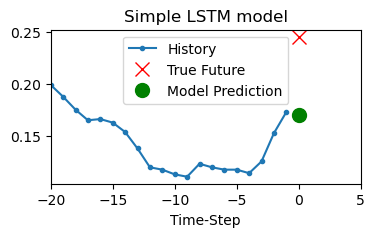

8/8 [==============================] - 0s 2ms/step


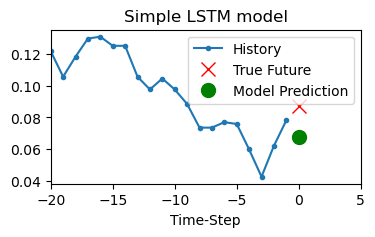

8/8 [==============================] - 0s 2ms/step


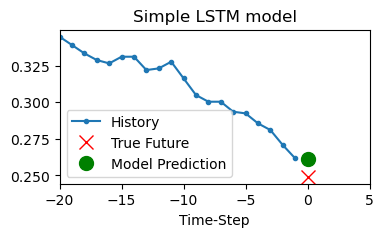

In [30]:
# 검증 데이터셋에서 예측 결과 시각화 

# Defind function for Visualization
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.figure(figsize=(4, 2))
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])  # plot_data[1] , plot_data[2] ... 이면 if
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])  # plot_data[0] 이면 else
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)])
    plt.xlabel('Time-Step')
    return plt

for x, y in val_univariate.take(3):   # 검증 데이터셋에서 처음 3개 값 추출
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

313/313 [==============================] - 1s 2ms/step
(10000, 20, 1) (10000,) (10000, 1)
Test MAE Loss: 0.02699359506368637


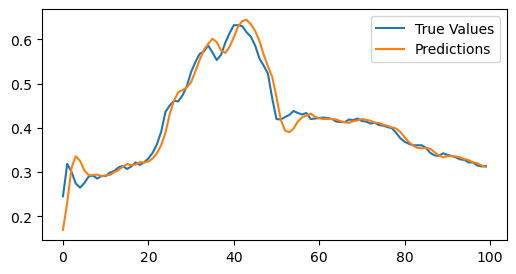

In [32]:
x_test_uni = x_val_uni[:10000]
y_test_uni = y_val_uni[:10000]
# 원래는 시작 단계부터 val, test 데이터셋 분리해야함 

predictions = simple_lstm_model.predict(x_test_uni)
print(x_test_uni.shape, y_test_uni.shape, predictions.shape)

# 예측 성능 평가 (MAE)
mae_loss = tf.keras.losses.MeanAbsoluteError()
test_loss = mae_loss(y_test_uni, predictions.flatten()).numpy() # flatten()에 유의할것.. 타겟과 예측값 shape 이 동일해야함

print(f"Test MAE Loss: {test_loss}")

plt.figure(figsize=(6, 3))
plt.plot(y_test_uni[:100], label='True Values')
plt.plot(predictions[:100], label='Predictions')
plt.legend()
plt.show()